In [1]:
# Computations
import numpy as np
import pandas as pd

# datetime
from datetime import datetime, timedelta

from collections import Counter

# Plots

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import missingno as msno

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

<img src='https://upload.wikimedia.org/wikipedia/commons/0/08/Netflix_2015_logo.svg' width='350' align="center"/>

TV Shows and Movies listed on Netflix
====================================

In this article, we analyze a dataset for Netflix tv shows and movies available at [kaggle.com](https://www.kaggle.com/shivamb/netflix-shows).

### Data Description

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flexible which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

### Inspiration
Some of the interesting questions (tasks) which can be performed on this dataset -

Understanding what content is available in different countries
Identifying similar content by matching text-based features
Network analysis of Actors / Directors and find interesting insights
Is Netflix has increasingly focusing on TV rather than movies in recent years?

### Loading the Data

In [2]:
Data = pd.read_csv("Data/netflix_titles.csv")

In [3]:
Data.head(5)

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   
3                             United States  September 8, 2018          2016   
4                             United States  September 8, 2017          2017   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   
3     TV-Y7  1 Season                            Kids' TV   
4     TV-14    99 min                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

First off, let's take a look at NaN values.

In [4]:
def Data_info(Inp, Only_NaN = False):
    Out = pd.DataFrame(Inp.dtypes,columns=['Data Type']).sort_values(by=['Data Type'])
    Out = Out.join(pd.DataFrame(Inp.isnull().sum(), columns=['Number of NaN Values']), how='outer')
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out

In [5]:
Data_info(Data)

Data Type  Number of NaN Values  Percentage
cast            object                   570        9.14
country         object                   476        7.64
date_added      object                    11        0.18
description     object                     0        0.00
director        object                  1969       31.58
duration        object                     0        0.00
listed_in       object                     0        0.00
rating          object                    10        0.16
release_year     int64                     0        0.00
show_id          int64                     0        0.00
title           object                     0        0.00
type            object                     0        0.00

This can be shown using a visualization of nullity by column.

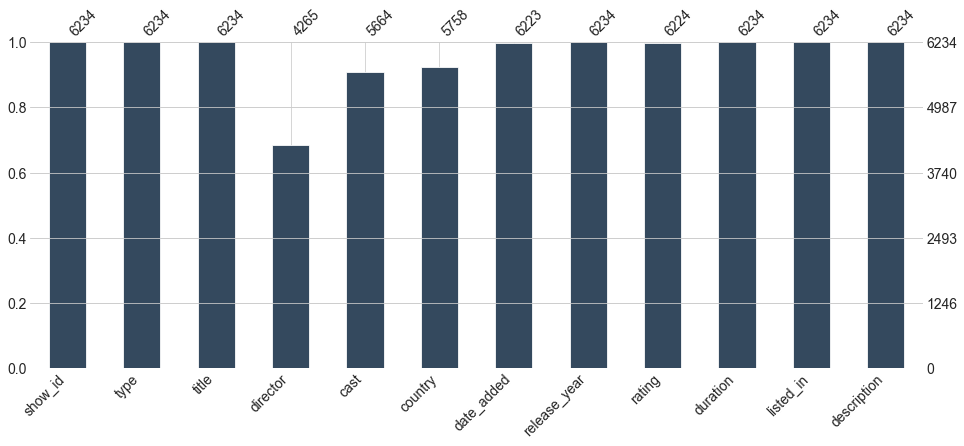

In [6]:
_ = msno.bar(Data, figsize=(16,6), fontsize=14, log=False, color="#34495e")

Moreover, the dendrogram graph shows correlate variable completion.

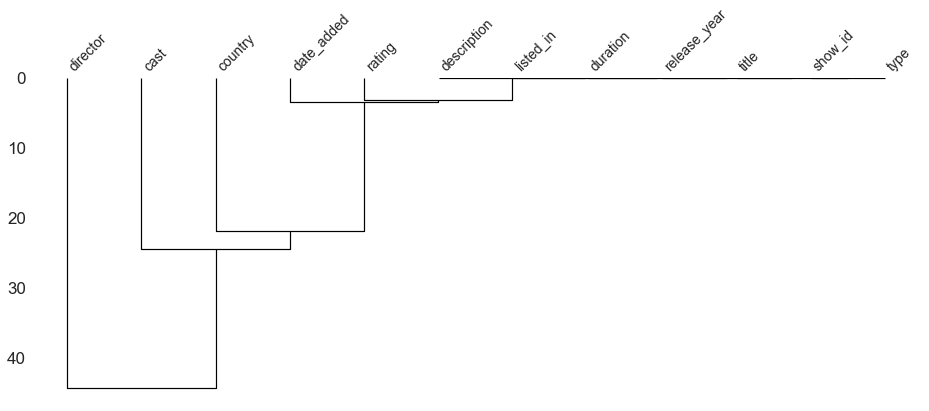

In [7]:
_ = msno.dendrogram(Data, figsize=(16,6), fontsize=14)

Furthermore,

In [8]:
Data.describe(include='all')[:4]

show_id   type      title                director                cast  \
count    6234.0   6234       6234                    4265                5664   
unique      NaN      2       6172                    3301                5469   
top         NaN  Movie  Limitless  Raúl Campos, Jan Suter  David Attenborough   
freq        NaN   4265          3                      18                  18   

              country       date_added  release_year rating  duration  \
count            5758             6223        6234.0   6224      6234   
unique            554             1524           NaN     14       201   
top     United States  January 1, 2020           NaN  TV-MA  1 Season   
freq             2032              122           NaN   2027      1321   

            listed_in                                        description  
count            6234                                               6234  
unique            461                                               6226  
top     Documentaries  A surly septuagenarian gets another chance at ...  
freq              299                                                  3

# Exploratory Data Analysis

## Year Added

We can replace all nan values in **date_added** column with *January 01, 2020*.

In [9]:
Data['date_added'] = pd.to_datetime(Data['date_added'].fillna('January 01, 2020'))

Adding features

In [10]:
Data['year_added'] = Data['date_added'].apply(lambda x: x.year).astype(int)
Data['month_added'] = Data['date_added'].apply(lambda x: x.month).astype(int)
Data['month_name'] = Data['date_added'].apply(lambda x: x.month_name())

In [11]:
Temp0 = Data.loc[Data.year_added< 2020].groupby(['year_added'])['year_added'].agg({'count'})
Temp0.sort_values(inplace = True, by=['year_added'])
Temp0.reset_index(inplace = True, drop= False)
Temp1 = Data.loc[Data.year_added< 2020].groupby(['type','year_added'])['year_added'].agg({'count'})
Temp1.sort_values(inplace = True, by=['year_added'])
Temp1.reset_index(inplace = True, drop= False)

Group = Temp1.merge(Temp0, left_on='year_added', right_on='year_added')
Group.rename(columns = {'count_x': 'count', 'count_y': 'total'},inplace = True)
Group['Percentage'] = 100*(Group['count']/Group['total'])
Group = Group.round(2)
del Temp0, Temp1
display(Group)

type  year_added  count  total  Percentage
0     Movie        2008      1      2       50.00
1   TV Show        2008      1      2       50.00
2     Movie        2009      2      2      100.00
3     Movie        2010      1      1      100.00
4     Movie        2011     13     13      100.00
5     Movie        2012      4      7       57.14
6   TV Show        2012      3      7       42.86
7     Movie        2013      6     12       50.00
8   TV Show        2013      6     12       50.00
9     Movie        2014     19     25       76.00
10  TV Show        2014      6     25       24.00
11  TV Show        2015     32     90       35.56
12    Movie        2015     58     90       64.44
13  TV Show        2016    192    456       42.11
14    Movie        2016    264    456       57.89
15  TV Show        2017    387   1300       29.77
16    Movie        2017    913   1300       70.23
17    Movie        2018   1290   1782       72.39
18  TV Show        2018    492   1782       27.61
19    Movie        2019   1546   2349       65.82
20  TV Show        2019    803   2349       34.18

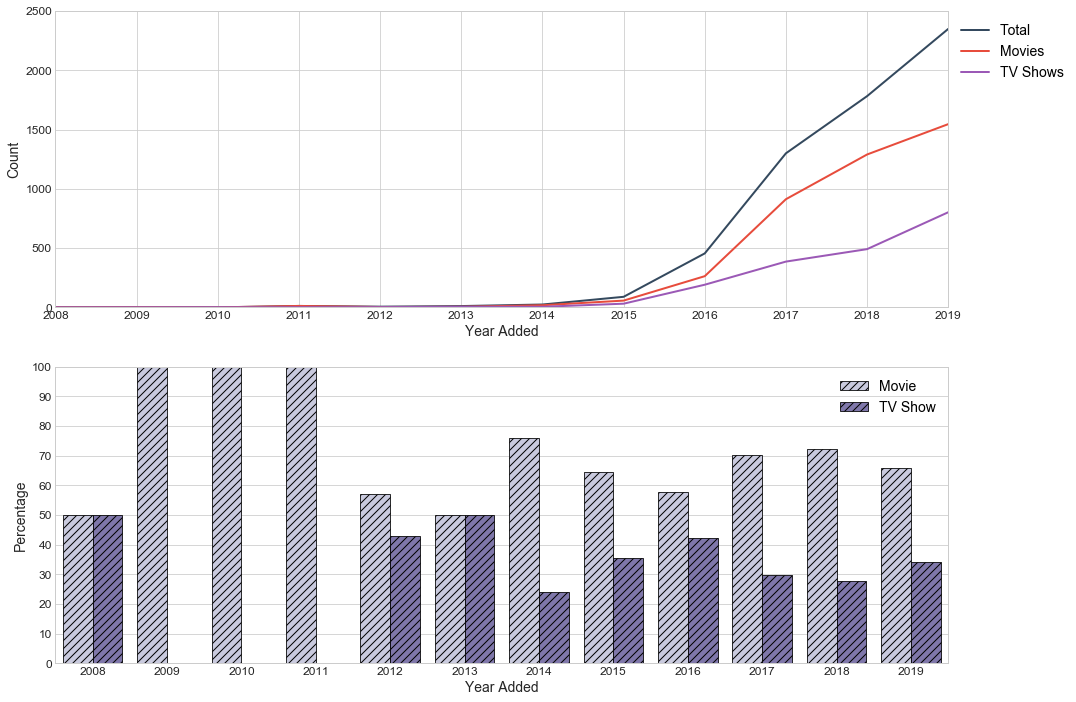

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
_ = Group.loc[Group.type == 'Movie'].plot(ax =ax[0], x= 'year_added',
                                                     y = 'total', color= '#34495e', linewidth=2, label='Total')
_ = Group.loc[Group.type == 'Movie'].plot(ax= ax[0], x= 'year_added',
                                                     y = 'count', color='#e74c3c', linewidth=2, label='Movies')
_ = Group.loc[Group.type == 'TV Show'].plot(ax= ax[0], x= 'year_added',
                                                       y = 'count', color='#9b59b6', linewidth=2, label='TV Shows')
_ = ax[0].set_ylim([0,2500])
_ = ax[0].set_xlim([Group.year_added.min(), Group.year_added.max()])
_ = ax[0].set_xticks(np.arange(Group.year_added.min(), Group.year_added.max()+1, 1))
_ = ax[0].set_xlabel('Year Added')
_ = ax[0].set_ylabel('Count')
_ = ax[0].legend(bbox_to_anchor=(1, 1), fontsize = 14)


_ = sns.barplot(ax = ax[1], x="year_added", y="Percentage", hue = 'type', palette='Purples',
                edgecolor='k',  hatch="///", data=Group)
_ = ax[1].legend(bbox_to_anchor=(1, 1), fontsize = 14)
_ = ax[1].set_ylim([0,100])
_ = ax[1].set_yticks(np.arange(0, 101, 10))
_ = ax[1].set_xlabel('Year Added')
_ = ax[1].set_ylabel('Percentage')

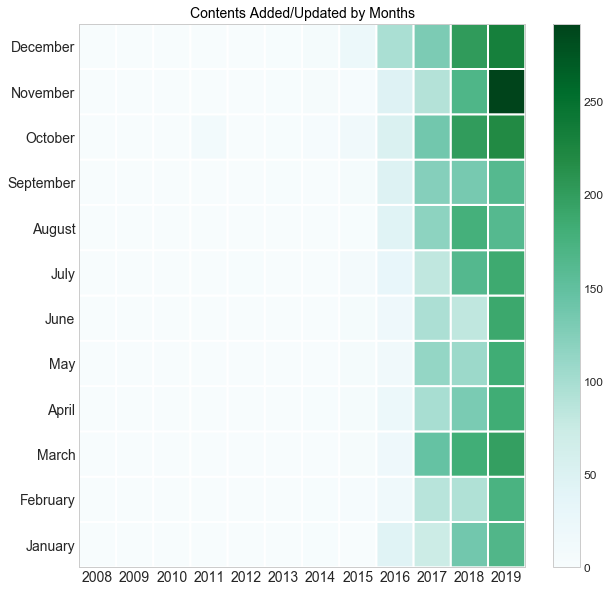

In [13]:
Group = Data.loc[Data.year_added<2020].groupby(['year_added',
                                                'month_added'])['year_added'].agg({'count'}).unstack().fillna(0).T

Temp = Data[['month_added','month_name']].sort_values(by=['month_added'])
Temp = Temp.month_name.unique().tolist()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
cs = ax.pcolor(Group, cmap='BuGn', edgecolors='white', linewidths=2)
_ = ax.set_xticks(np.arange(0.5, len(Group.columns), 1))
_ = ax.set_xticklabels(Group.columns, fontsize = 14)
_ = ax.set_yticks(np.arange(0.5, len(Group.index), 1))
_ = ax.set_yticklabels(Temp, fontsize = 14)
_ = ax.set_title('Contents Added/Updated by Months', fontsize=14)
_ = fig.colorbar(cs, ax=ax, shrink=1)

Comparing this data with [Netflix timeline data](https://en.wikipedia.org/wiki/Timeline_of_Netflix), we can get some explanations behind this growth.

## Country

We can define the following function to separate the values in each column.

In [14]:
def Col_Sep(Col, df = Data):
    Out = pd.Series(dict(Counter(", ".join(df[Col].dropna()).split(", "))))
    Out = Out.sort_values(ascending = False)
    Out = pd.DataFrame(Out).reset_index(drop = False)
    return Out

In [15]:
Group = Col_Sep('country')
Group.columns = ['Country','Count']

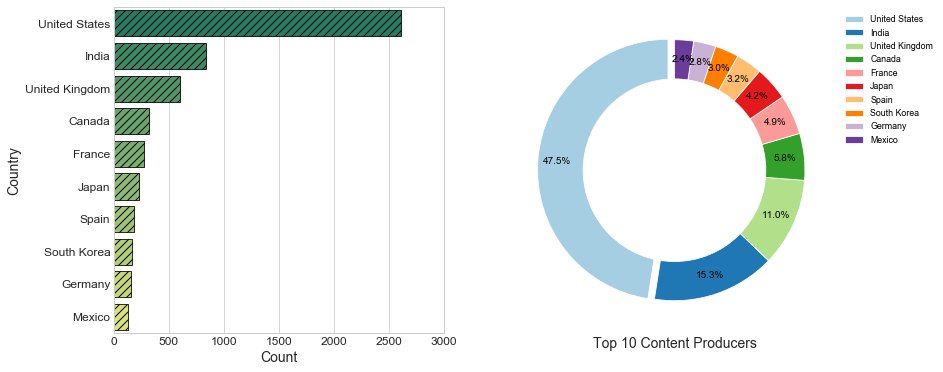

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

_ = sns.barplot(ax = ax[0], y="Country", x="Count", palette='summer',
                edgecolor='k',  hatch="///", data = Group[:10])
_ = ax[0].set_xlim([0, 3e3])

Top = 10
E = [0 for _ in range(Top)]
E[0] = 0.05
_ = Group[:Top].plot.pie(ax = ax[1],y= 'Count', startangle=90, label = '', labels = None,
                         colors = sns.color_palette("Paired"), legend=True, autopct='%1.1f%%', fontsize=10,
                         pctdistance=0.85, explode = E)

_ = ax[1].legend(bbox_to_anchor=(1, 1), labels= Group[:Top].Country)
_ = ax[1].add_artist(plt.Circle((0,0),0.70,fc='white'))
_ = ax[1].set_xlabel('Top %i Content Producers' % Top, fontsize = 14)

## Rating

Netflix used the following table to decide the maturity rating on TV shows and movies [[source](https://help.netflix.com/en/node/2064/us)].

| Little Kids   | Older Kids                 | Teens        | Mature          |
|---------------|----------------------------|--------------|-----------------|
| G, TV-Y, TV-G | PG, TV-Y7, TV-Y7-FV, TV-PG | PG-13, TV-14 | R, NC-17, TV-MA |

Moreover, the [Motion Picture Association of America film rating system](https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system) (MPAA) film ratings are as follows

|Rating|Meaning|
|-|-|
|G|General Audiences|
|PG|Parental Guidance Suggested|
|PG-13|Parents Stongly Cautioned|
|R|Restricted|
|NC-17|Adults Only|
|Unrated|Unrated|

In [17]:
Group = Data.dropna().groupby(['type','rating'])['rating'].agg({'count'})
Group.reset_index(drop = False, inplace = True)
print('Movie Ratings:')
Group['rating group'] = np.nan
Group.loc[Group.rating.isin(['G', 'TV-Y', 'TV-G']), 'rating group'] = 'Little Kids'
Group.loc[Group.rating.isin(['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']), 'rating group'] = 'Older Kids'
Group.loc[Group.rating.isin(['PG-13', 'TV-14']), 'rating group'] = 'Teens'
Group.loc[Group.rating.isin(['R', 'NC-17', 'TV-MA']), 'rating group'] = 'Mature'
Group.loc[Group.rating.isin(['NR', 'UR']), 'rating group'] = 'Unrated'
Group.sort_values(by=['rating group'], inplace = True)
display(Group.style.hide_index())

Movie Ratings:


Therefore,

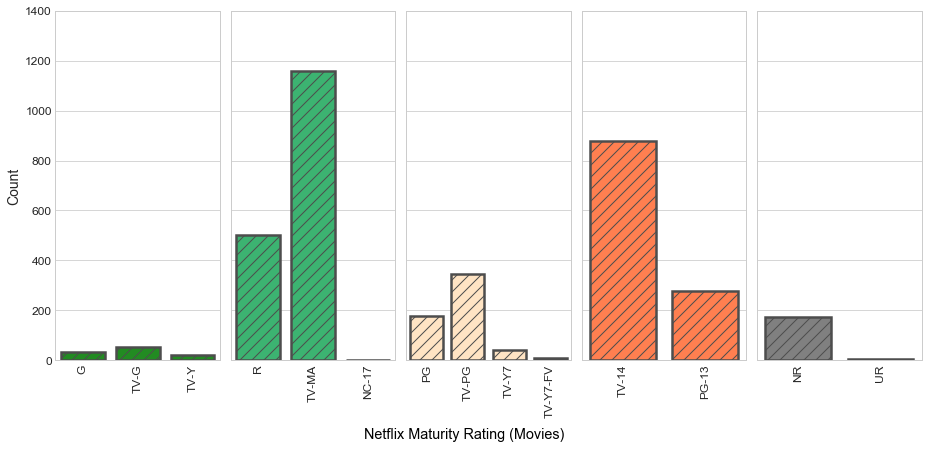

In [18]:
RG = Group.loc[(Group.type == 'Movie'), 'rating group'].unique()

fig, ax = plt.subplots(nrows=1, ncols=len(RG), figsize=(13, 6), sharey = True)
C =  ['forestgreen','mediumseagreen','bisque','coral','gray']

for i in range(len(RG)):
    Temp = Group.loc[(Group.type == 'Movie') & (Group['rating group'] == RG[i])]
    _ = sns.barplot(ax=ax[i], x='rating', y ='count', data=Temp, linewidth=2.5,
                    facecolor=C[i], errcolor=".3", edgecolor=".3", hatch = '//')
    _ = ax[i].set_xlabel(None)
    _ = ax[i].set_ylabel(None)
    _ = ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    
_ = ax[0].set_ylim([0,1400])  
_ = ax[0].set_ylabel('Count')
st = fig.suptitle("Netflix Maturity Rating (Movies)", fontsize="x-large")
st.set_y(0)

del RG, C, Temp
fig.tight_layout()

In [19]:
Group.loc[(Group.type == 'TV Show')]

type rating  count rating group
16  TV Show   TV-G      1  Little Kids
19  TV Show   TV-Y      3  Little Kids
14  TV Show      R      1       Mature
17  TV Show  TV-MA     32       Mature
18  TV Show  TV-PG     14   Older Kids
20  TV Show  TV-Y7      6   Older Kids
15  TV Show  TV-14     39        Teens

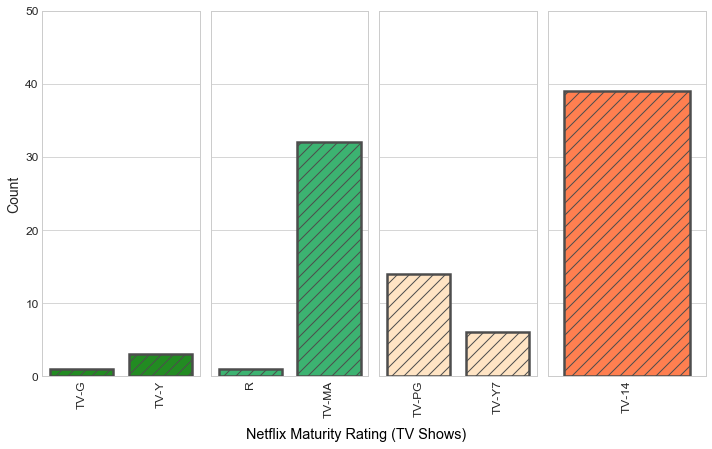

In [20]:
RG = Group.loc[(Group.type == 'TV Show'), 'rating group'].unique()

fig, ax = plt.subplots(nrows=1, ncols=len(RG), figsize=(10, 6), sharey = True)
C =  ['forestgreen','mediumseagreen','bisque','coral','gray']

for i in range(len(RG)):
    Temp = Group.loc[(Group.type == 'TV Show') & (Group['rating group'] == RG[i])]
    _ = sns.barplot(ax=ax[i], x='rating', y ='count', data=Temp, linewidth=2.5,
                    facecolor=C[i], errcolor=".3", edgecolor=".3", hatch = '//')
    _ = ax[i].set_xlabel(None)
    _ = ax[i].set_ylabel(None)
    _ = ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    
_ = ax[0].set_ylim([0,50])  
_ = ax[0].set_ylabel('Count')
st = fig.suptitle("Netflix Maturity Rating (TV Shows)", fontsize="x-large")
st.set_y(0)

del RG, C, Temp
fig.tight_layout()

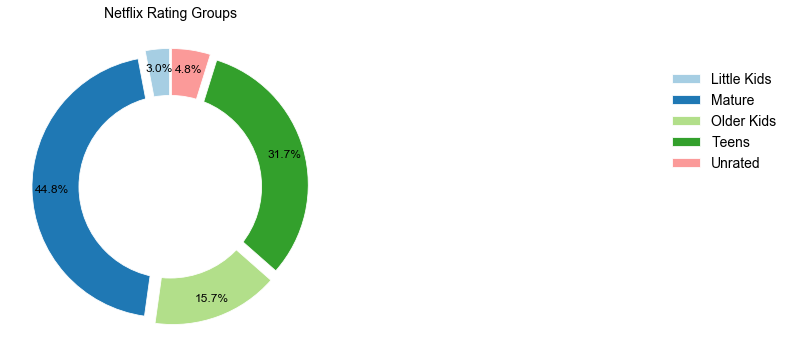

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), sharey = True)

Temp = Group.groupby(['rating group'])['count'].agg({'sum'})

E = [0.06 for _ in range(len(Temp))]
# E[0] = 0.05
_ = Temp.plot.pie(ax = ax,y= 'sum', startangle=90, label = '', labels = None,
                         colors = sns.color_palette("Paired"), legend=True, autopct='%1.1f%%', fontsize=12,
                         pctdistance=0.85, explode = E)
_ = ax.legend(bbox_to_anchor=(2, 0.7), loc="center left", labels= Temp.index, fontsize = 14)
_ = ax.add_artist(plt.Circle((0,0),0.70,fc='white'))
_ = ax.set_title('Netflix Rating Groups')

## Categories

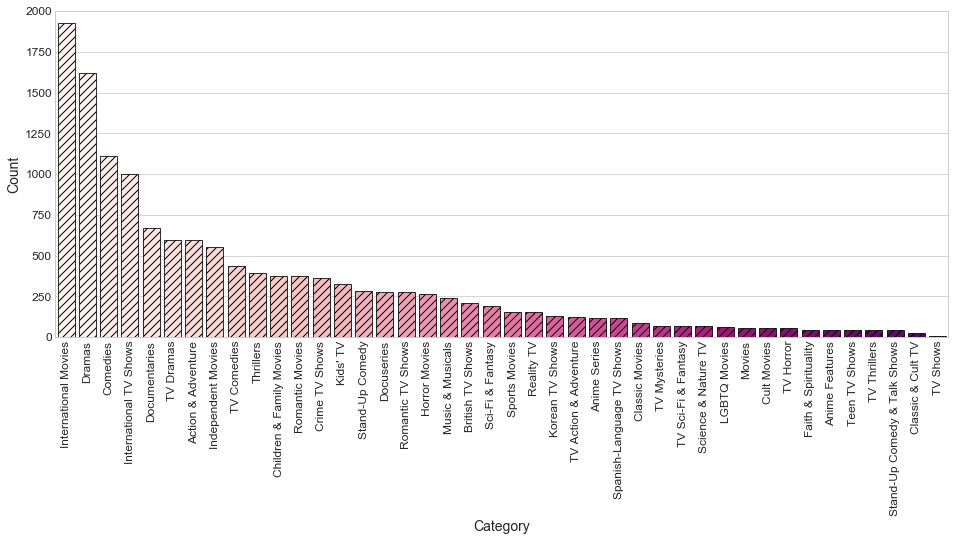

In [22]:
Group = Col_Sep('listed_in')
Group.columns = ['Category','Count']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), sharey = True)
_ = sns.barplot(ax = ax, x="Category", y="Count", palette='RdPu', edgecolor='k',  hatch="///", data=Group)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 12)
_ = ax.set_ylim([0,2e3])

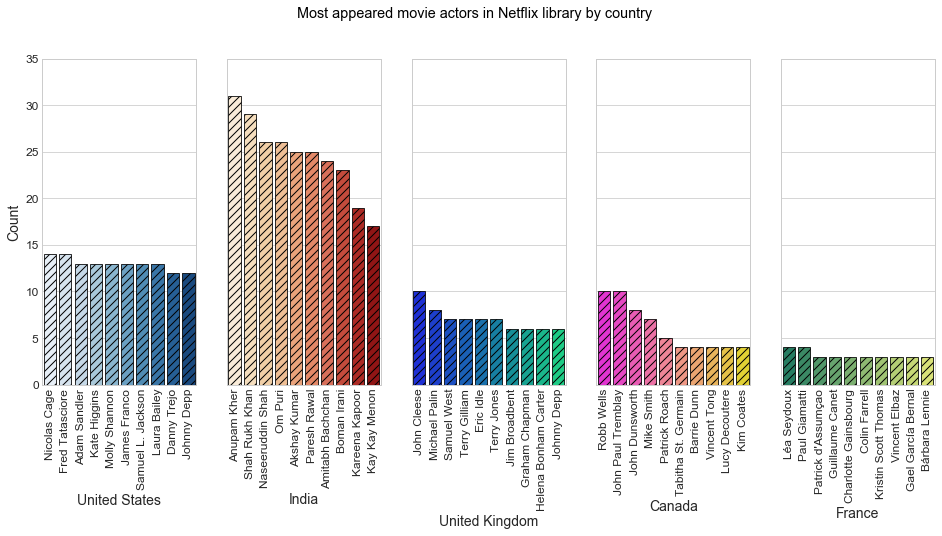

In [23]:
Top = 10
Group = Col_Sep('country', Data.loc[Data.type == 'Movie'])
Group.columns = ['Country','Count']
Temp = Group[:5]['Country'].tolist()
del Group
i = Temp[0]
Temp0 =Data.loc[(Data['country'].str.contains(i, regex=False) ==True) & (Data.type == 'Movie')]
Temp0 = Col_Sep('cast', df = Temp0)[:Top]
Temp0['Country'] = i
Group = Temp0.copy()
for i in Temp[1:]:
    Temp0 =Data.loc[(Data['country'].str.contains(i, regex=False) ==True) & (Data.type == 'Movie')]
    Temp0 = Col_Sep('cast', df = Temp0)[:Top]
    Temp0['Country'] = i
    Group = pd.concat([Group, Temp0])
    del Temp0
    
Group.columns = ['Actor', 'Count', 'Country']


fig, ax = plt.subplots(nrows=1, ncols=len(Temp), figsize=(16, 6), sharey = True)
C =  ['Blues','OrRd','winter','spring','summer']

for i in range(len(Temp)):
    Temp0 = Group.loc[(Group['Country'] == Temp[i])]
    _ = sns.barplot(ax=ax[i], x='Actor', y ='Count', data=Temp0, palette= C[i], edgecolor='k',  hatch="///")
    _ = ax[i].set_xlabel(Temp[i])
    _ = ax[i].set_ylabel(None)
    _ = ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
del Temp, Temp0

_ = ax[0].set_ylim([0,35])  
_ = ax[0].set_ylabel('Count')
st = fig.suptitle("Most appeared movie actors in Netflix library by country", fontsize="x-large")
st.set_y(1)

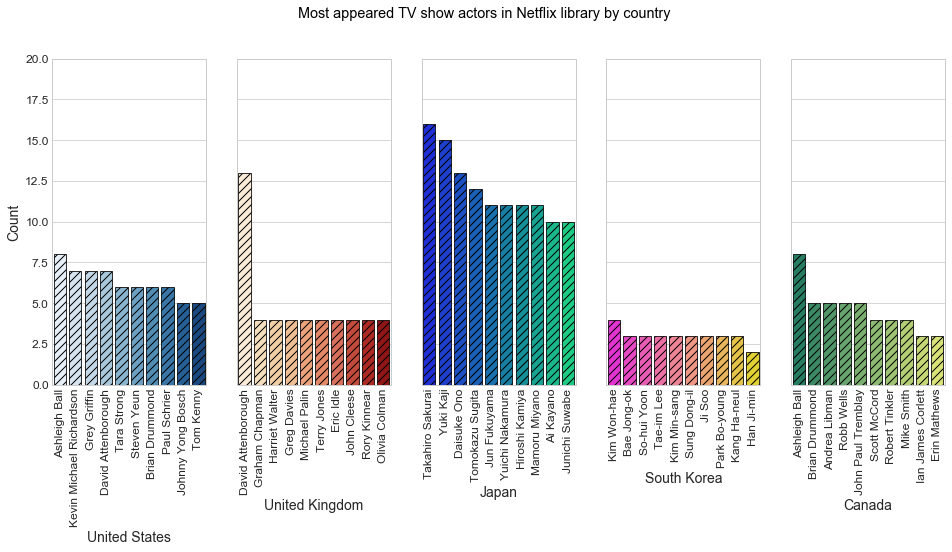

In [24]:
Top = 10
Group = Col_Sep('country', Data.loc[Data.type == 'TV Show'])
Group.columns = ['Country','Count']
Temp = Group[:5]['Country'].tolist()
del Group
i = Temp[0]
Temp0 =Data.loc[(Data['country'].str.contains(i, regex=False) ==True) & (Data.type == 'TV Show')]
Temp0 = Col_Sep('cast', df = Temp0)[:Top]
Temp0['Country'] = i
Group = Temp0.copy()
for i in Temp[1:]:
    Temp0 =Data.loc[(Data['country'].str.contains(i, regex=False) ==True) & (Data.type == 'TV Show')]
    Temp0 = Col_Sep('cast', df = Temp0)[:Top]
    Temp0['Country'] = i
    Group = pd.concat([Group, Temp0])
    del Temp0
    
Group.columns = ['Actor', 'Count', 'Country']


fig, ax = plt.subplots(nrows=1, ncols=len(Temp), figsize=(16, 6), sharey = True)
C =  ['Blues','OrRd','winter','spring','summer']

for i in range(len(Temp)):
    Temp0 = Group.loc[(Group['Country'] == Temp[i])]
    _ = sns.barplot(ax=ax[i], x='Actor', y ='Count', data=Temp0, palette= C[i], edgecolor='k',  hatch="///")
    _ = ax[i].set_xlabel(Temp[i])
    _ = ax[i].set_ylabel(None)
    _ = ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
del Temp, Temp0

_ = ax[0].set_ylim([0,20])  
_ = ax[0].set_ylabel('Count')
st = fig.suptitle("Most appeared TV show actors in Netflix library by country", fontsize="x-large")
st.set_y(1)

***